In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data_path = pathlib.Path("C:/小圖片/food_pic200_640")
category = 10

In [3]:

# 訓練、驗證資料集
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    image_size=(320,320),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    image_size=(320,320),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Found 2000 files belonging to 10 classes.
Using 400 files for validation.


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.1),
    layers.experimental.preprocessing.RandomRotation(factor=0.2),
    layers.GaussianNoise(0.2),
])

In [5]:
inputs = layers.Input(shape=(320, 320, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=(320, 320, 3),
    pooling=None
)

# Freeze the base ResNet50 layers
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(category, activation='softmax')(x)

model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00252) 
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 320, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 320, 320, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 159, 159, 32) 864         rescaling[0][0]                  
______________________________________________________________________________________________

In [47]:
# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                          mode="min")

# ModelCheckpoint
checkpoint = ModelCheckpoint('inceptionV3.{epoch:03d}-{val_loss:.4f}.pb',
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode="max")  

callbacks = [early_stop, checkpoint]

In [48]:
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath='InceptionV3_{epoch:02d}_{val_loss:4f}.pb',
#         save_best_only=True,
#         monitor='val_loss',
#         verbose=0
#     )
# ]

In [49]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/200
50/50 [==============================] - 16s 274ms/step - loss: 1.4415 - acc: 0.5306 - val_loss: 0.5829 - val_acc: 0.8675
INFO:tensorflow:Assets written to: inceptionV3.001-0.5829.pb\assets
Epoch 2/200
50/50 [==============================] - 13s 261ms/step - loss: 0.5985 - acc: 0.8206 - val_loss: 0.3531 - val_acc: 0.9175
INFO:tensorflow:Assets written to: inceptionV3.002-0.3531.pb\assets
Epoch 3/200
50/50 [==============================] - 13s 262ms/step - loss: 0.4294 - acc: 0.8731 - val_loss: 0.2913 - val_acc: 0.9400
INFO:tensorflow:Assets written to: inceptionV3.003-0.2913.pb\assets
Epoch 4/200
50/50 [==============================] - 14s 264ms/step - loss: 0.3289 - acc: 0.8969 - val_loss: 0.2274 - val_acc: 0.9450
INFO:tensorflow:Assets written to: inceptionV3.004-0.2274.pb\assets
Epoch 5/200
50/50 [==============================] - 14s 264ms/step - loss: 0.2743 - acc: 0.9194 - val_loss: 0.1865 - val_acc: 0.9550
INFO:tensorflow:Assets written to: inceptionV3.005-0.1865.

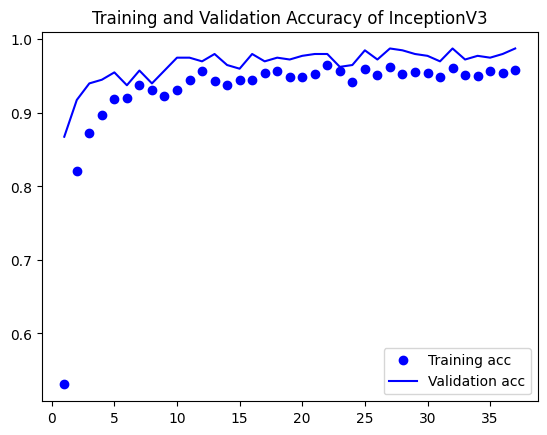

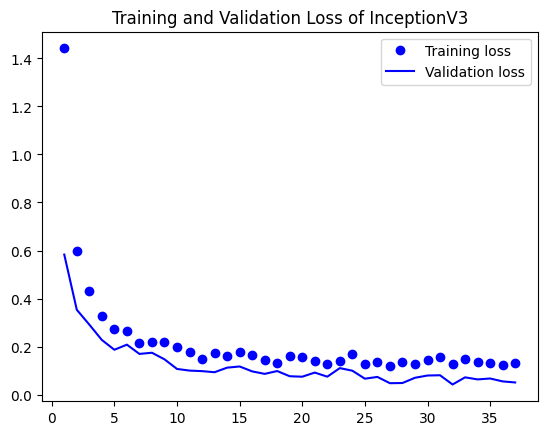

In [50]:
# Plotting training and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy of InceptionV3")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss of InceptionV3")
plt.legend()
plt.show()